# Import Necessary Libraries

In [86]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random as r
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import colormaps
from matplotlib import cm
import scipy.stats
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
import folium
from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi
from math import radians, cos, sin, asin, sqrt, floor

In [52]:
def map_state_names_to_ids(state_names):
    state_name_to_id = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',
        "District of Columbia": "DC"
    }
    state_ids = [state_name_to_id.get(state, state) for state in state_names]
    return state_ids


# Import Data Files

In [53]:
og_df1 = pd.read_csv('ufos.csv',header=0).drop(columns='redundant')
df = og_df1.dropna().copy()
statedf = pd.read_csv('2019_Census_US_Population_Data_By_State_Lat_Long.csv', header=0)
statedf['State_ID'] = map_state_names_to_ids(statedf['STATE'])
statedf.rename(columns={'POPESTIMATE2019': 'Population'}, inplace=True)
df.to_csv('export.csv')
citydf = pd.read_csv('uscities.csv')
citydf.drop(columns=['zips'], inplace=True)

c_latitudes = citydf["lat"]
c_longitudes = citydf["lng"]

df.head(5)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,10/10/1956 21:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
2,10/10/1960 20:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
3,10/10/1961 19:00,bristol,tn,us,sphere,300.0,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889
4,10/10/1965 23:45,norwalk,ct,us,disk,1200.0,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333


# Country Sighting Percentages Represented on Pie Chart

In [54]:
country_group = df.groupby('country')['country'].count().sort_values(ascending=False)
total_count = country_group.sum()

percentages = (country_group / total_count) * 100
trans_countrynames = {"us": "United States", "ca": "Canada", "gb": "Great Britain", "au": "Australia"}
country_group.index = country_group.index.map(trans_countrynames)

# Create a pie chart
fig = px.pie(
    names=country_group.index,
    values=percentages,
    labels={'names': 'Country'},
    width=500,
    height=500,
)
fig.update_layout(
    font=dict(
        size=12,       
        family="Computer Modern, Times New Roman, serif"  
    ) 
)
fig.update_traces(textinfo='percent+label')

fig.show()

# Plot all sighting locations on world map

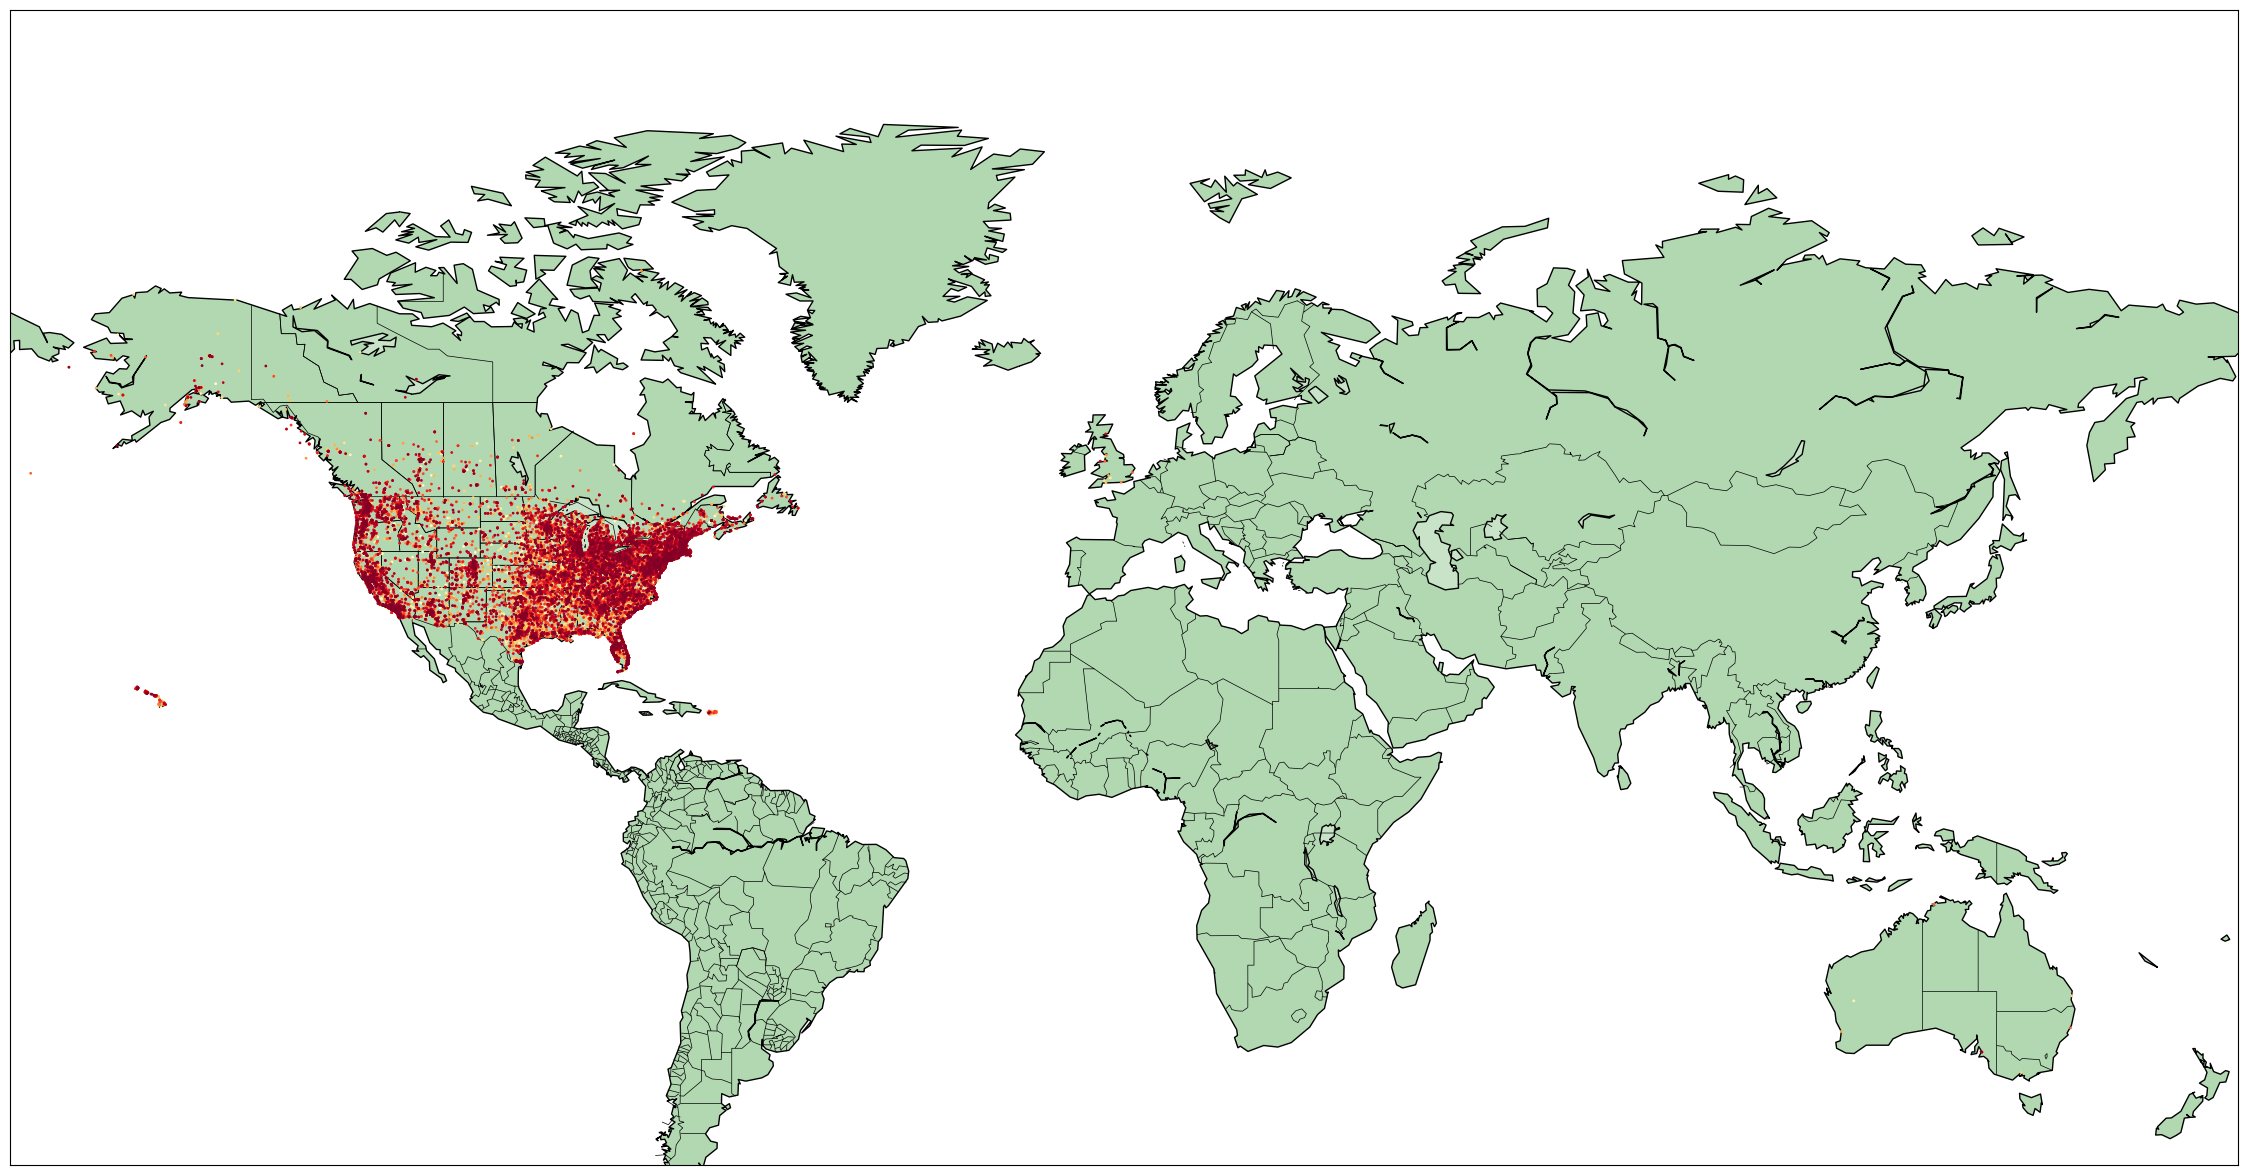

In [55]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(30,15))
m = Basemap(projection='mill',
           llcrnrlat = -50,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')

m.drawstates()
m.drawcountries()
m.drawcoastlines()

lat, long = df['latitude'].tolist(), df['longitude'].tolist()

t = np.arange(66516)

m.scatter(long, lat, marker = 'o', c=t, cmap='YlOrRd', s=1, zorder=10, latlon=True)
m.fillcontinents(color='g', alpha =0.3)


plt.show()

## Drop all countries which are not the US to eliminate bias

In [56]:
df = df.sort_values('date posted',ascending=True).reset_index(drop=True)

df = df[df['country'] == 'us']
df = df.drop(df[df["state"] == "pr"].index)

### Central Tendencies and Measures of Spread for Numerical Variables

In [57]:
df.describe().style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '14px'})

,duration (seconds),latitude,longitude
count,63529.000000,63529.000000,63529.000000
mean,1276.703597,38.330631,-95.589253
std,11761.801324,5.542089,18.055615
min,0.010000,19.063889,-176.658056
25%,30.000000,34.101389,-114.405000
50%,180.000000,38.951667,-89.990556
75%,600.000000,41.900000,-80.945278
max,604800.000000,70.636944,-66.984722


# Data formatting to make calculations easier later on

In [58]:
df['datetime'] = df['datetime'].str.replace("24:00", "00:00")

df['datetime'] = pd.to_datetime(df['datetime'], format="%m/%d/%Y %H:%M")
df['datetime'] = pd.to_datetime(df['datetime'])

ufo_yr = df['datetime'].dt.year

years_data = ufo_yr.value_counts()
years_index = years_data.index
years_values = years_data.values
df['year'] = df['datetime'].dt.year


### Central Tendencies of Date Time

In [92]:
print("Median =", df['datetime'].dt.year.median())
print("Mean =", floor(df['datetime'].dt.year.mean()))
print("Mode =", df['datetime'].dt.year.value_counts().index[0])

Median = 2007.0
Mean = 2004
Mode = 2012


## Bar Graph of Sightings vs Time

In [94]:
fig = px.bar(x=years_index[:60], y=years_values[:60], labels={'x': 'Year', 'y': 'Count'})

fig.update_layout(
    xaxis_tickangle=-60,
    height=600,
    width=900,
    font=dict(
        size=16,
        family="Computer Modern, Times New Roman, serif"
    )
)

fig.show()


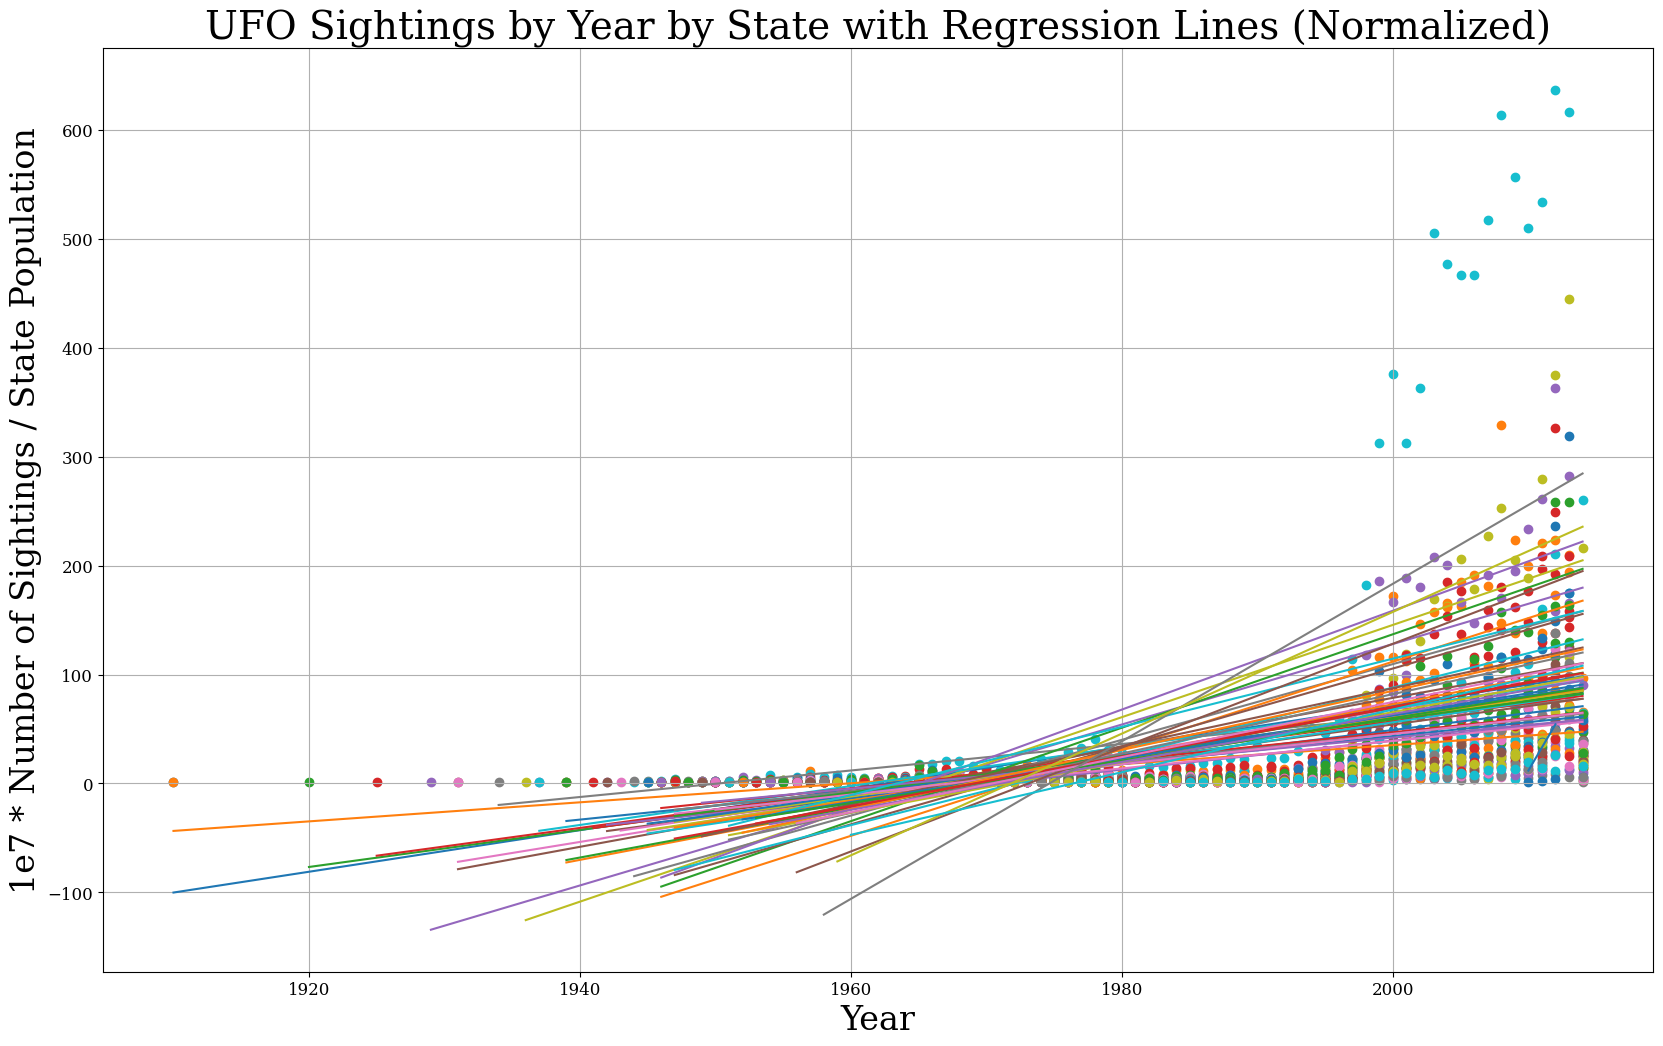

In [61]:
coef = []
plt.figure(figsize=(20, 12))
sightings_by_year_state = df.groupby(['year', 'state']).size().reset_index(name='count')

for state in sightings_by_year_state['state'].unique():
    state_data = sightings_by_year_state[sightings_by_year_state['state'] == state]
    plt.scatter(state_data['year'], state_data['count'])
    pop = statedf[statedf["State_ID"] == state.upper()]["Population"]
    # Perform linear regression
    X = state_data[['year']]
    y = 10000000* state_data['count']/pop.values[0]
    reg = LinearRegression().fit(X, y)
    coef.append(reg.coef_)
    predictions = reg.predict(X)
    
    plt.plot(X, predictions)

plt.xlabel('Year', fontsize=24)
plt.ylabel('1e7 * Number of Sightings / State Population', fontsize=24)
plt.title('UFO Sightings by Year by State with Regression Lines (Normalized)', fontsize=28)
plt.grid(True)
plt.show()

### Measures of Central Tendency and Spread for the Slopes

In [62]:
X = np.array(years_index[:60]).reshape(-1, 1)
y = np.array(years_values[:60])

model = LinearRegression()
model.fit(X, y)

# Get the slope and intercept
slope = model.coef_[0]
intercept = model.intercept_
print(slope, intercept)

arr = np.array(coef[:-1])
mean = np.mean(arr)
median = np.median(arr)
 
# measures of spread
min1 = np.amin(arr)
max1 = np.amax(arr)
range1 = np.ptp(arr)
variance = np.var(arr)
sd = np.std(arr)
 
print("Measures of Central Tendency")
print("Mean =", mean)
print("Median =", median)
print("Measures of Dispersion")
print("Minimum =", min1)
print("Maximum =", max1)
print("Range =", range1)
print("Variance =", variance)
print("Standard Deviation =", sd)

69.82462274958252 -137510.400102834
Measures of Central Tendency
Mean = 2.46155368352172
Median = 2.0116233985593723
Measures of Dispersion
Minimum = 0.8753901926585711
Maximum = 7.2326554645089525
Range = 6.357265271850381
Variance = 1.5503885540176008
Standard Deviation = 1.2451459970692598


## Bar Graph for Sightings by Month

In [63]:
order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
df['month'] = df['datetime'].dt.month_name()  
month_data = df['month'].value_counts()
month_index = month_data.index
month_values = month_data.values

month_cat = pd.Categorical(month_index[:60], categories=order, ordered=True)

sorted_data = sorted(zip(month_cat, month_values[:60]), key=lambda x: order.index(x[0]))

sorted_month_index, sorted_month_values = zip(*sorted_data)

fig = go.Figure(data=go.Bar(x=sorted_month_index, y=sorted_month_values, marker_color='rgb(124, 176, 230)'))

std_deviation = np.std(sorted_month_values)
print(f"Standard Deviation of Sightings Frequency: {std_deviation}")

fig.update_layout(
    title='UFO Sightings by Month',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    xaxis_tickangle=-60,
    height=400,
    width=800,
    font=dict(
        size=15,
        family="Computer Modern, Times New Roman, serif"
    )
)

fig.show()

Standard Deviation of Sightings Frequency: 1167.8011715993819


## Histogram of Sightings by Hour

In [64]:
fig = px.histogram(df, x=df['datetime'].dt.hour, nbins=24, labels={'datetime': 'Hour', 'count': 'Frequency'},
                   color_discrete_sequence=['rgb(124, 176, 230)'])
fig.update_layout(
    title='UFO Sightings by Hour',
    xaxis=dict(title='Hour'),
    yaxis=dict(title='Frequency'),
    height=400,
    width=800,
    font=dict(
        size=15,       
        family="Computer Modern, Times New Roman, serif"  
    ) 
)
fig.show()

In [65]:
pd.DataFrame(sorted_month_values).describe()

,0
count,12.000000
mean,5294.083333
std,1219.728543
min,3675.000000
25%,4311.250000
50%,5013.000000
75%,6152.500000
max,7521.000000


In [66]:
df["datetime"].describe()

count                            63529
mean     2004-09-27 15:31:41.500102272
min                1910-01-01 00:00:00
25%                2001-12-22 12:30:00
50%                2007-06-07 22:00:00
75%                2011-09-01 01:55:00
max                2014-05-08 00:00:00
Name: datetime, dtype: object

## Frequency vs Duration Graph with Logarithmic Regression Line

The very long x axis combined with a small amplitude diaplays the magnitude of outliers present in the dataset

In [67]:
df["duration (seconds)"].value_counts()[:10]

duration (seconds)
300.0    6969
120.0    5695
600.0    5015
60.0     4604
180.0    4094
900.0    3234
30.0     2904
10.0     2640
Name: count, dtype: int64

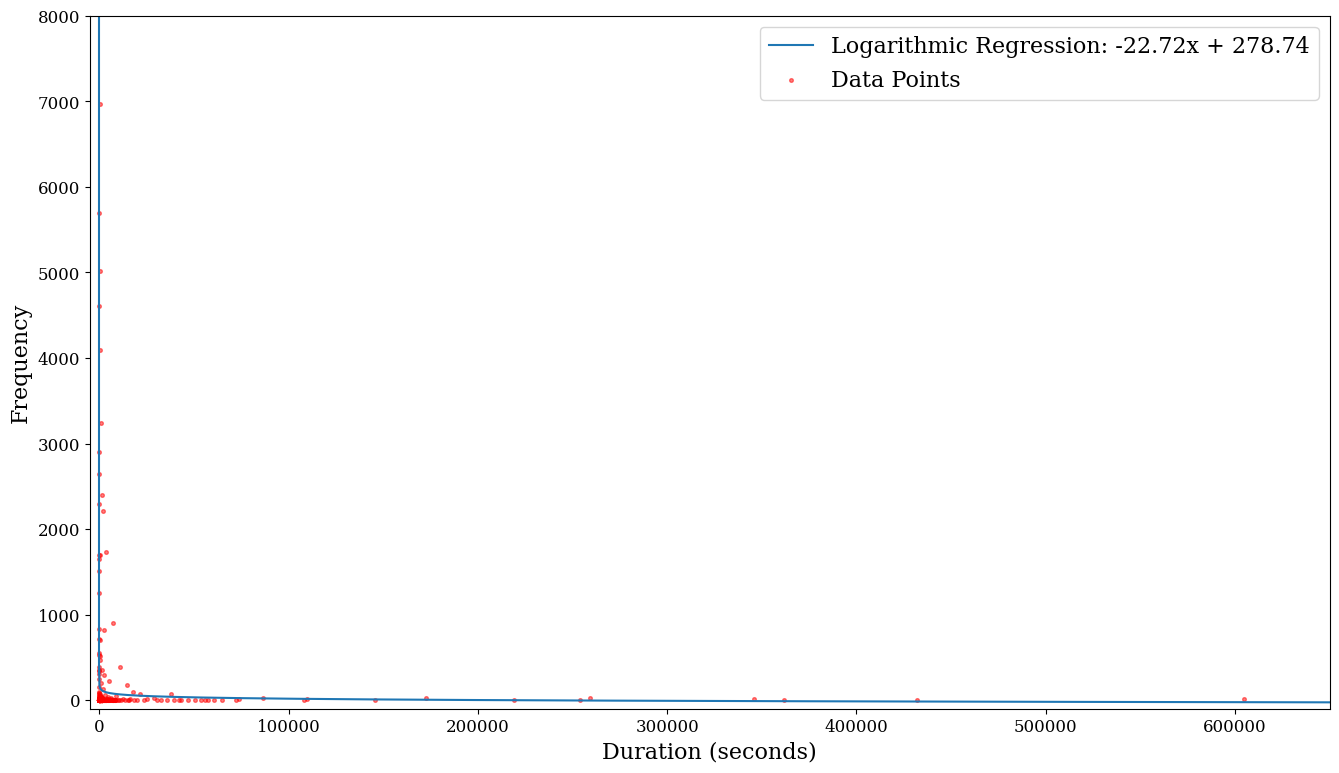

In [68]:
x = df['duration (seconds)'].value_counts().sort_index().index.to_numpy()
y = df['duration (seconds)'].value_counts().sort_index().values

coefficients = np.polyfit(np.log(x), y, 1)
log_reg_line = np.poly1d(coefficients)

x_range = np.linspace(0.01, 650000, 10000)  
y_pred = log_reg_line(np.log(x_range))

plt.figure(figsize=(16, 9))
plt.plot(x_range, y_pred, label=f'Logarithmic Regression: {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
plt.scatter(x, y, color='red', label='Data Points', s=7, alpha=0.5)

plt.axvline(x=0, ymin=0.05, ymax=1)

plt.xlabel('Duration (seconds)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(fontsize=16)
plt.xlim(-5000, 650000)
plt.ylim(-100, 8000)
plt.tick_params(axis='both', labelsize=12)

plt.show()

## Boxplot for Duration

<Axes: >

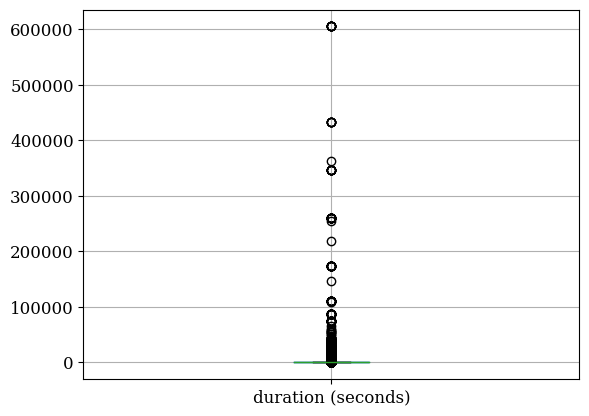

In [69]:
df.boxplot(column='duration (seconds)')

## Z-score for 600000 seconds

In [96]:
data = df['duration (seconds)']

z_scores = scipy.stats.zscore(data)

print("Z-score:", z_scores.max())

Z-score: 51.3125523711325


# Heatmaps

In [71]:
df_temp = df.copy()
df_temp['state'] = df_temp['state'].str.upper()
fig = px.choropleth(
    df_temp.groupby(['state'])['state'].count().reset_index(name='Sightings'),
    locations='state',
    color='Sightings',
    color_continuous_scale='greys',
    locationmode = 'USA-states',
    height=500,
    width=800
)

fig.update_layout(
    #title_text = 'Total UFO sightings by state',
    geo_scope='usa', # limite map scope to USA
)
fig.update_coloraxes(
    colorbar_tickfont=dict(
            size=16,       
            family="Computer Modern, Times New Roman, serif"  
        ) ,
    colorbar_title_font=dict(
            size=16,       
            family="Computer Modern, Times New Roman, serif"  
        ) 
    )
fig.show()

In [72]:
cdf_temp = citydf.copy()
fig = px.choropleth(
    statedf,
    locations='State_ID',
    color='Population',
    color_continuous_scale='greys',
    locationmode = 'USA-states',
    height=500,
    width=800
)

fig.update_layout(
    #title_text = 'Population Density by state',
    geo_scope='usa', # limite map scope to USA        
)
fig.update_coloraxes(
    colorbar_tickfont=dict(
            size=16,       
            family="Computer Modern, Times New Roman, serif"  
        ) ,
    colorbar_title_font=dict(
            size=16,       
            family="Computer Modern, Times New Roman, serif"  
        ) 
    )

fig.show()

# Clustering

In [97]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r

#### The following code fits the sightings and population data to K-means classifiers and then plots all cluster centroids on a map of the USA

In [74]:
data2 = df.copy()
data2.dropna(subset=['latitude', 'longitude'])

latitudes = data2["latitude"]
longitudes = data2["longitude"]

X = pd.concat([latitudes, longitudes], axis=1)

n_clusters = 100 

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

data2["cluster"] = kmeans.labels_

citydf = pd.read_csv('uscities.csv')
citydf.drop(columns=['zips'], inplace=True)

c_latitudes = citydf["lat"]
c_longitudes = citydf["lng"]

citydf.head()

# Create a KMeans model and fit it to the data
cX = pd.concat([c_latitudes, c_longitudes], axis=1)

c_kmeans = KMeans(n_clusters=n_clusters)
c_kmeans.fit(cX)

# Add cluster labels to the DataFrame
citydf["cluster"] = c_kmeans.labels_
cluster_pop = citydf.groupby("cluster")["population"].sum()


cluster_sightings = data2.groupby("cluster").size()


adj=[[]for i in range(n_clusters)]
for i in range(n_clusters):
    for j in range(n_clusters):
        dist = haversine(kmeans.cluster_centers_[i][1], kmeans.cluster_centers_[i][0], c_kmeans.cluster_centers_[j][1], c_kmeans.cluster_centers_[j][0])
        adj[i].append(dist)
kt = []
visited = [False for i in range(n_clusters)]
for i in range(n_clusters):
    best = [10000000, 0]
    for j in range(n_clusters):
        if (adj[i][j] < best[0]):
            best[0] = adj[i][j]
            best[1] = j
    visited[best[1]] = True;
    kt.append(best[1])

total_population = citydf['population'].sum()

cluster_pop_proportion = (cluster_pop / total_population)
cluster_sights_proportion = (cluster_sightings / df.shape[0])



data1 = {'Latitude': kmeans.cluster_centers_.T[0], 'Longitude': kmeans.cluster_centers_.T[1]}
data2 = {'Latitude': c_kmeans.cluster_centers_.T[0], 'Longitude': c_kmeans.cluster_centers_.T[1]}
df1 = pd.DataFrame(data1)

df2 = pd.DataFrame(data2)

fig = px.choropleth(
    statedf,
    locations='State_ID',
    color='Population',
    locationmode = 'USA-states',
    color_continuous_scale='greys',
    height=500,
    width=800
    #height=400,
    #width=400
)
fig.add_scattergeo(
    lat=df1['Latitude'],
    lon=df1['Longitude'],
    mode='markers',
    marker=dict(
        size=10,
        color='blue',  
        opacity=0.7,
    ),
    name='Cluster Centers (UFO Sightings)'
)

fig.add_scattergeo(
    lat=df2['Latitude'],
    lon=df2['Longitude'],
    mode='markers',
    marker=dict(
        size=10,
        color='red', 
        opacity=0.7,
    ),
    
    name='Cluster Centers (Populations)'
)
fig.update_layout(coloraxis_showscale=False,legend=dict(
        orientation="h",  
        yanchor="top",     
        y=1.1,            
        font=dict(
            size=16,       
            family="Computer Modern, Times New Roman, serif"  
        ) 
    ))

fig.update_geos(
    scope='usa',
    showcoastlines=True, 
)

fig.show()

/home/alexz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



/home/alexz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Using Matplotlib and numpy, plot the data on a 3d graph and then fit a plane of regression

/tmp/ipykernel_17374/844898557.py:23: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



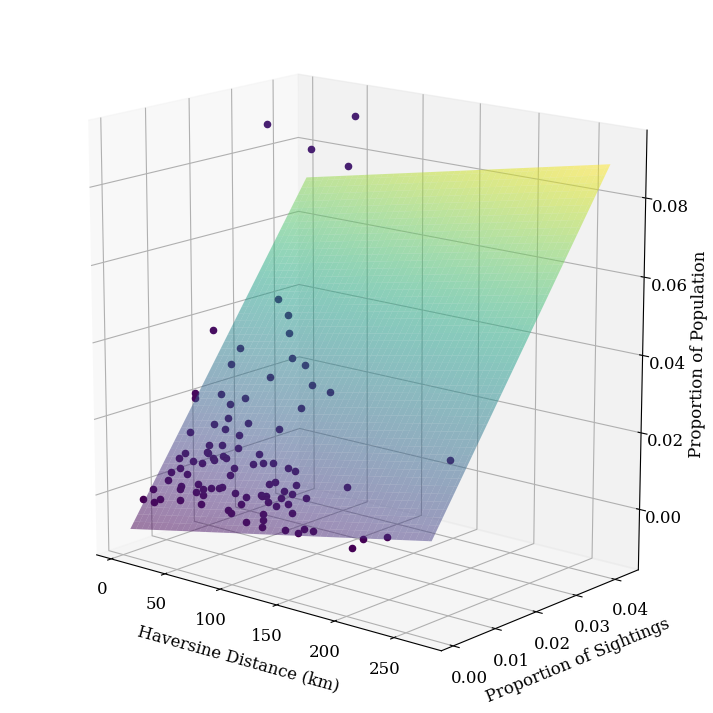

[ 6.52617740e-05  1.87020433e+00 -9.75001807e-03]
Correlation Coefficient (Pearson's R): 0.76


In [75]:
x = []  
y = []  
z = [] 

colormap = plt.get_cmap('viridis')

fig = plt.figure(figsize=(24, 9))
ax = fig.add_subplot(111, projection='3d')

for i in range(n_clusters):
    x_value = haversine(kmeans.cluster_centers_[i][1], kmeans.cluster_centers_[i][0], c_kmeans.cluster_centers_[kt[i]][1], c_kmeans.cluster_centers_[kt[i]][0])
    y_value = cluster_sights_proportion[i]
    z_value = cluster_pop_proportion[kt[i]]
    
    x.append(x_value)
    y.append(y_value)
    z.append(z_value)

    color = colormap(z_value)

    ax.scatter(x_value, y_value, z_value, c=color)

A = np.column_stack((x, y, np.ones_like(x)))
B = z
coefficients, residuals, _, _ = np.linalg.lstsq(A, B, rcond=None)

x_plane, y_plane = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
z_plane = coefficients[0] * x_plane + coefficients[1] * y_plane + coefficients[2]

ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.5, cmap='viridis', antialiased=True)
plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "serif"

ax.set_xlabel('Haversine Distance (km)', labelpad=8)
ax.set_ylabel('Proportion of Sightings')
ax.set_zlabel('Proportion of Population', labelpad=5)


ax.view_init(elev=15, azim=-50)
ax.set_box_aspect([2.5, 1.75, 2.5])
plt.show()

x = np.array(x)
y = np.array(y)

z_pred = coefficients[0] * x + coefficients[1] * y + coefficients[2]
correlation_coefficient = np.corrcoef(z, z_pred)[0, 1]
print(coefficients)
print(f'Correlation Coefficient (Pearson\'s R): {correlation_coefficient:.2f}')


# Combine Data for States and Sightings

In [77]:
combined_data = statedf.merge(
    df_temp.groupby(['state'])['state'].count().reset_index(name='Sightings'),
    left_on='State_ID', right_on='state', how='inner'
)
combined_data.drop(columns=["State_ID", "state", "lat", "long"])

,STATE,Population,Sightings
0,Alabama,4903185,629
1,Alaska,731545,311
2,Arizona,7278717,2362
3,Arkansas,3017804,578
4,California,39512223,8683
5,Colorado,5758736,1385
6,Connecticut,3565287,865
7,Delaware,973764,165
8,District of Columbia,705749,7
9,Florida,21477737,3754


## Plot Sightings vs State on a Graph and Fit a Line of Regression to it

In [80]:
fig = px.scatter(combined_data, x='Population', y='Sightings',
                 title='UFO Sightings vs Population by State', height=600, width=900)

fig.update_layout(
    xaxis_title='Population',
    yaxis_title='Sightings',
    xaxis=dict(range=[0, combined_data['Population'].max() * 1.025]),  
    yaxis=dict(range=[0, combined_data['Sightings'].max() * 1.05]),
    font=dict(
        size=16,
        family="Computer Modern, Times New Roman, serif"
    )
)

fig.update_traces(textposition='top center', showlegend=False, textfont=dict(size=None), marker=dict(size=10))

import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array(combined_data['Population']).reshape(-1, 1)
y = np.array(combined_data['Sightings'])
reg = LinearRegression().fit(X, y)
predicted_y = reg.predict(X)

fig.add_scatter(x=combined_data['Population'], y=predicted_y, mode='lines', showlegend=False)
print(f'Linear Regression: y = {reg.coef_[0]:.10f}x + {reg.intercept_:.10f}')
print(f'Correlation Coefficient (Pearson\'s R): {correlation_coefficient:.2f}')

fig.show()

Linear Regression: y = 0.0001763231x + 110.8389168036
Correlation Coefficient (Pearson's R): 0.76


## Create Residuals Graph to Better Visualize Data

In [82]:
residuals = y - predicted_y
residuals_fig = go.Figure()
residuals_fig.add_trace(go.Scatter(x=combined_data['Population'], y=residuals, mode='markers'))
residuals_fig.add_trace(go.Scatter(x=combined_data['Population'], y=[0] * len(combined_data), mode='lines', name='Zero Residuals'))

residuals_fig.update_layout(
    title='Residuals Plot',
    xaxis_title='Population',
    yaxis_title='Residuals',
    showlegend=False,
    font=dict(
        size=16,
        family="Computer Modern, Times New Roman, serif"
    )
)

residuals_fig.show()